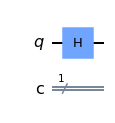

In [1]:
import qiskit
from qiskit import *
from qiskit import Aer

# Create a Quantum Circuit acting on a single qubit
circ = QuantumCircuit(1,1)

# Add a Hadamard (H) gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# circ.draw()
circ.draw(output='mpl')


#the second wire represent